In [16]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from dataclasses import dataclass
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

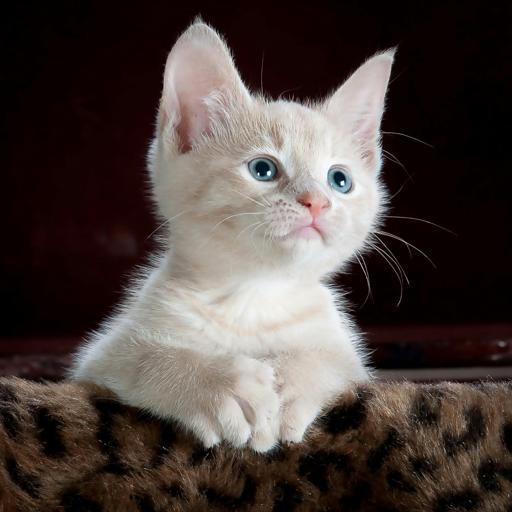

In [6]:

img=Image.open("image.jpg")

img

In [3]:
## using hugging face transformers
from transformers import AutoProcessor, SiglipVisionModel,SiglipVisionConfig

processor=AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
vision_model=SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224",config=SiglipVisionConfig(vision_use_head=False))

vision_model

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(196, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bi

In [12]:
def preprocess_image(image, image_size=224):
    preprocess=transforms.Compose([
        transforms.Resize([image_size,image_size]),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485,0.456,0.406],
            std=[0.229,0.224,0.225]
        )
    ])

    image_tensor=preprocess(image) # (3,224,224) RGB --> now add batch size as well
    image_tensor=image_tensor.unsqueeze(0)
    return image_tensor


image_tensor=preprocess_image(img)

embed_dim=768
patch_size=16
image_size=224
num_patches=(image_size //  patch_size) **2

with torch.no_grad():
    patch_embedding=nn.Conv2d(in_channels=3,out_channels=embed_dim,kernel_size=patch_size,stride=patch_size)
    patches=patch_embedding(image_tensor) ## non-overlapping patches

patches.shape, num_patches ## shape of each patch and total number of patches

(torch.Size([1, 768, 14, 14]), 196)

In [13]:
## creating position embedding (dummy) --> basically a lookup table
position_embedding=nn.Embedding(num_patches,embed_dim)
#position_ids=torch.arange(num_patches).expand(-1,1)
position_ids=torch.arange(num_patches).unsqueeze(0)

position_ids.shape


torch.Size([1, 196])

In [15]:
## now flattening the image tensor and adding positional encodings
#embeddings=patches.flatten(start_dim=2,end_dim=-1)
embeddings=patches.contiguous().view(1,768,-1)
embeddings=embeddings.transpose(1,2)

embeddings=embeddings+position_embedding(position_ids)
print(embeddings.shape)

torch.Size([1, 196, 768])


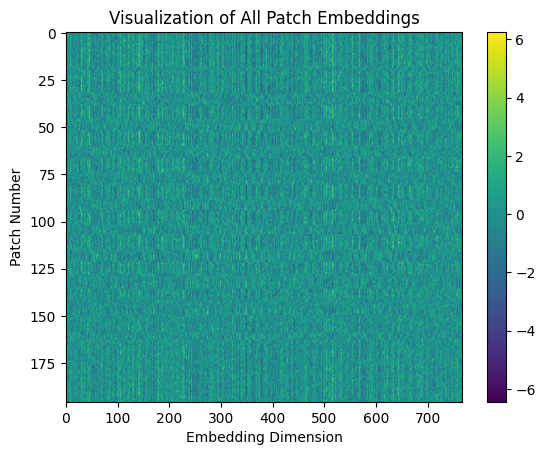

In [20]:
## visualizing the patches
patches_vis=embeddings[0].detach().numpy()

plt.figure(figure=(15,8))
plt.imshow(patches_vis,aspect="auto",cmap="viridis")
plt.colorbar()
plt.title('Visualization of All Patch Embeddings')
plt.xlabel('Embedding Dimension')
plt.ylabel('Patch Number')
plt.show()

torch.Size([1, 196, 768])


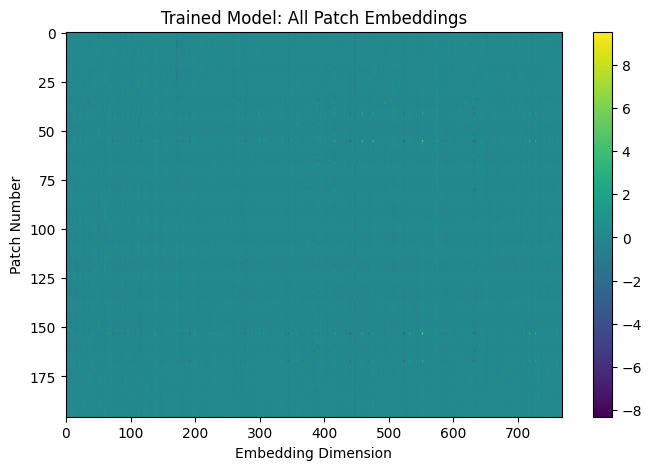

In [24]:
vision_model.eval()
inputs = processor(images=img, return_tensors="pt")

with torch.no_grad():
    patch_embeddings = vision_model.vision_model.embeddings(inputs.pixel_values)

print(patch_embeddings.shape)

patches_viz = patch_embeddings[0].detach().numpy()  # Shape: [196, 768]

plt.figure(figsize=(8, 5))
plt.imshow(patches_viz, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Trained Model: All Patch Embeddings')
plt.xlabel('Embedding Dimension')
plt.ylabel('Patch Number')
plt.show()